In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import operator
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage
from skimage.io import imread, imshow, imsave

# **Crop**

In [4]:
def crop_center(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

# **Directory**

In [10]:
'''Source Path'''
train_all_path = r'/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/Train - 1 to 100 ratio/all'
train_hem_path = r'/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/Train - 1 to 100 ratio/hem'

In [11]:
train_all_list = os.listdir(train_all_path)
train_all_list.sort()

train_hem_list = os.listdir(train_hem_path)       # augment this
train_hem_list.sort()



print('train/all: ', len(train_all_list))
print('train/hem :', len(train_hem_list))

train/all:  33
train/hem : 770


In [12]:
train_all_batch = np.zeros((len(train_all_list), 210, 210, 3), dtype=np.uint8)
train_hem_batch = np.zeros((len(train_hem_list), 210, 210, 3), dtype=np.uint8)    # augment this


print(train_all_batch.shape, train_hem_batch.shape)

(33, 210, 210, 3) (770, 210, 210, 3)


# **Read, Crop Function**

In [13]:
def Read_n_Crop(list_data, batch, path):
    i=0
    for x in list_data:
        image = imread(os.path.join(path, x))
        image = crop_center(image, (210,210,3))
        batch[i] = image
        i+=1

    print(type(batch), batch.shape, batch.dtype, batch[0].shape, batch[0].dtype)

augment

In [14]:
Read_n_Crop(train_all_list, train_all_batch, train_all_path)
Read_n_Crop(train_hem_list, train_hem_batch, train_hem_path)

<class 'numpy.ndarray'> (33, 210, 210, 3) uint8 (210, 210, 3) uint8
<class 'numpy.ndarray'> (770, 210, 210, 3) uint8 (210, 210, 3) uint8


# **Save Crop image in other directory**


In [15]:
'''Save Oversampled Cropped Images'''
def SaveOC_images(list_data, path, batch):
    for x in range(len(list_data)):
#         print(path)
        new_path = path + '/' + list_data[x]
        print(new_path)
#         break
        imsave(new_path ,batch[x])


In [16]:
path = '/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all'
SaveOC_images(train_all_list, path, train_all_batch)
path = '/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/hem'
SaveOC_images(train_hem_list, path, train_hem_batch)     # augment this

/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/UID_11_12_2_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/UID_11_37_1_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/UID_15_15_1_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/UID_16_28_2_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/UID_17_28_3_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/UID_20_8_1_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/UID_21_38_5_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/UID_23_21_1_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/UID_25_5_3_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/UI

# **See Saved Image**

In [17]:
def Plot_images(batch, num):
    i=0
    plt.figure(figsize=(15,15))
    for x in batch:
        if 0<=i<(num*num):
            plt.subplot(num,num,i+1)
            plt.imshow(x)
        else:
            break
        i +=1

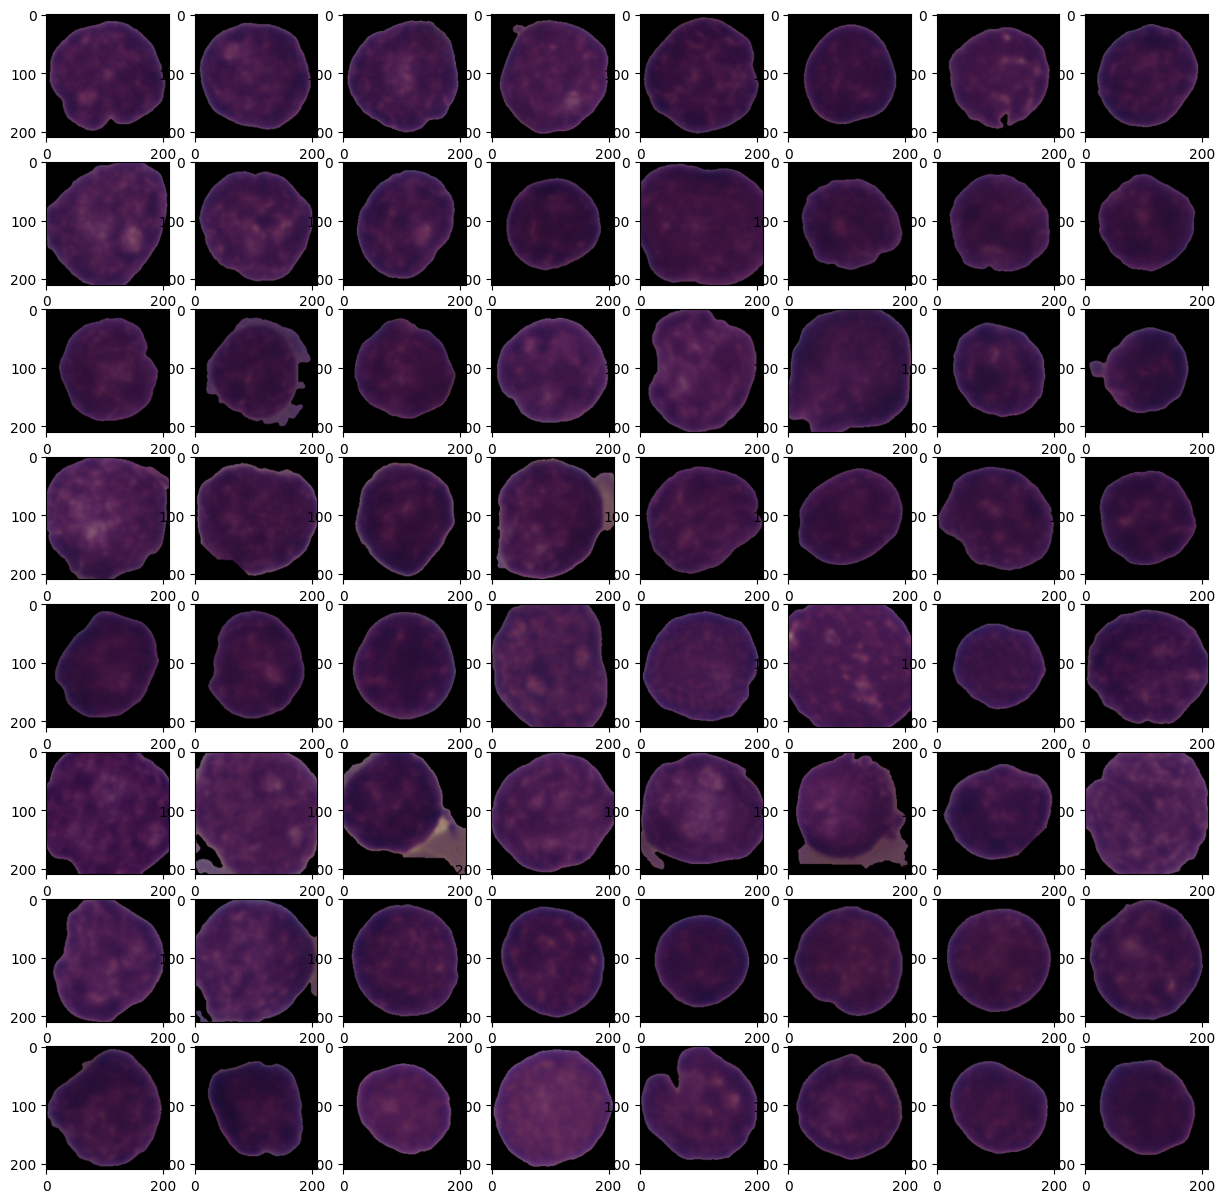

In [18]:
num = 8 # row n col
Plot_images(train_hem_batch, num)

# **Augmentation Pipeline**

In [19]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
         iaa.Crop(percent=(0, 0.1)), # random crops

        sometimes(iaa.CropAndPad(
            pad_mode=ia.ALL,
            percent=(-0.05, 0.1),
            pad_cval=(0, 255)
        )),

      sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees

        )),
],
random_order=True
)

# **Augment and Save**

In [20]:
def AugmentNsave_images(seq, batch, list_data, path, n):
    '''Augment'''
    images_aug = seq(images=batch)
    print(type(images_aug), images_aug.shape, images_aug.dtype, np.max(images_aug), np.min(images_aug), images_aug[0].shape, images_aug[0].dtype, np.max(images_aug[0]), np.min(images_aug[0]))
    '''Save'''
    for x in range(len(list_data)):
        #print(path)
        new_path = path + '/' + str(n) + 'Aug_' + list_data[x]
        print(new_path)
        imsave(new_path ,images_aug[x])

# **10 times augment**

In [21]:
'''Each time augmented results are different'''
times2augment = 10
path = '/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all'
for x in range(times2augment):
    AugmentNsave_images(seq,train_all_batch, train_all_list, path, x+1)


<class 'numpy.ndarray'> (33, 210, 210, 3) uint8 209 0 (210, 210, 3) uint8 147 0
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/1Aug_UID_11_12_2_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/1Aug_UID_11_37_1_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/1Aug_UID_15_15_1_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/1Aug_UID_16_28_2_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/1Aug_UID_17_28_3_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/1Aug_UID_20_8_1_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/1Aug_UID_21_38_5_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbalance/10x Aug/all/1Aug_UID_23_21_1_all.bmp
/content/drive/MyDrive/MRA/Assignment-1/Datasets/C-NMC/High Imbal